## Step 1
Initial labeling. This is the first step we are going to generate synthethized voices and label them as 0 and 1.


In [24]:
import os
notebook_dir = os.getcwd()  
ROOT_DIR = os.path.dirname(notebook_dir)
transcripts_path = os.path.join(ROOT_DIR, 'assets', 'audio', 'transcripts', 'transcripts.csv')


original_audio_path = os.path.join(ROOT_DIR, 'assets', 'audio', 'original_audio')
processed_audio_path = os.path.join(ROOT_DIR, 'assets', 'audio', 'processed_audio', 'real')

In [3]:
import librosa, numpy as np, scipy, matplotlib, sklearn, pandas as pd

In [41]:
from gtts import gTTS
import os

transcripts = pd.read_csv(transcripts_path)
len(transcripts)

58

Let's transform the wav to mp3 since wav is lossless

In [5]:
from pydub import AudioSegment

os.makedirs(processed_audio_path, exist_ok=True)

for file in os.listdir(processed_audio_path):
    if file.endswith('.wav'):
        os.remove(os.path.join(processed_audio_path, file))
        
for fname in os.listdir(original_audio_path):
    if fname.endswith(".mp3"):
        mp3_path = os.path.join(original_audio_path, fname)
        wav_path = os.path.join(processed_audio_path, fname.replace(".mp3", ".wav"))
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")

In [42]:
os.makedirs(generated_audio_path, exist_ok=True)


for index, row in transcripts.iterrows():
    text = row['text']
    id = row['id']
    tts = gTTS(text=text, lang='en')
    filename = f"{id}_fake.wav"
    tts.save(os.path.join(generated_audio_path, filename))

print(f'{len(transcripts)} audio files saved in {generated_audio_path}')

58 audio files saved in /Users/giovannipoveda/Documents/deepfake_voice_clonning/assets/audio/processed_audio/fake


In [7]:
data = []

for fname in os.listdir(processed_audio_path):
    if fname.endswith('.wav'):
        data.append({"file": os.path.join(processed_audio_path, fname), "label": "real"})

for fname in os.listdir(generated_audio_path):
    if fname.endswith('.wav'):
        data.append({"file": os.path.join(generated_audio_path, fname), "label": "fake"})

labeled_data = pd.DataFrame(data)





**Definition**: MFCCs represent the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. They aim to mimic the way humans perceive sound, especially how we’re more sensitive to certain frequency ranges (like speech).


In [8]:
def extract_mfcc(path, n_mfcc=13):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

labeled_data["features"] = labeled_data["file"].apply(extract_mfcc)

In [9]:
from sklearn.model_selection import train_test_split

X = np.stack(labeled_data["features"].values)
y = labeled_data["label"].map({"real": 0, "fake": 1}).values  

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
X

array([[-4.49278320e+02,  1.18245857e+02,  9.20156479e+00, ...,
        -3.86398840e+00, -5.77921629e+00, -9.59560299e+00],
       [-4.62927307e+02,  7.92914505e+01, -2.05132931e-01, ...,
         3.16822720e+00, -6.06962633e+00, -1.13924532e+01],
       [-4.43149445e+02,  1.21675804e+02,  2.25510144e+00, ...,
         1.97753870e+00, -4.54358625e+00, -1.42795229e+01],
       ...,
       [-3.25828400e+02,  8.69392853e+01, -6.53132725e+00, ...,
        -7.37703896e+00,  1.10690079e+01, -8.97767830e+00],
       [-2.81674408e+02,  8.22084198e+01, -1.91662598e+01, ...,
        -1.49567060e+01,  8.07485485e+00, -1.49616203e+01],
       [-2.84672272e+02,  6.93278046e+01, -1.52376699e+01, ...,
        -1.21701221e+01,  8.96357918e+00, -1.20660257e+01]], dtype=float32)

In [11]:
print("Train labels:", pd.Series(y_train).value_counts())
print("Test labels:", pd.Series(y_test).value_counts())

Train labels: 0    48
1    45
dtype: int64
Test labels: 1    12
0    12
dtype: int64


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



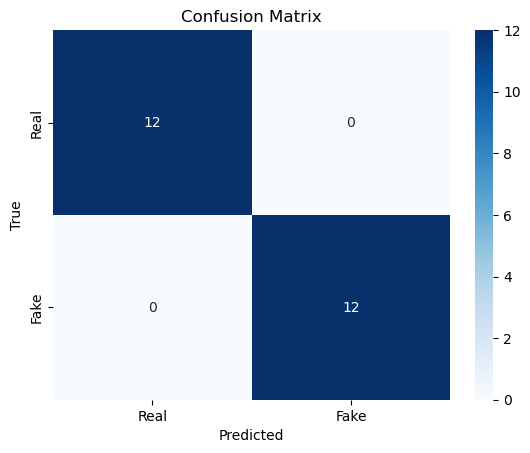

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

This are not good numbers for generalization. Maybe adding more samples will help out

In [14]:
print(pd.Series(y_test).value_counts())

1    12
0    12
dtype: int64


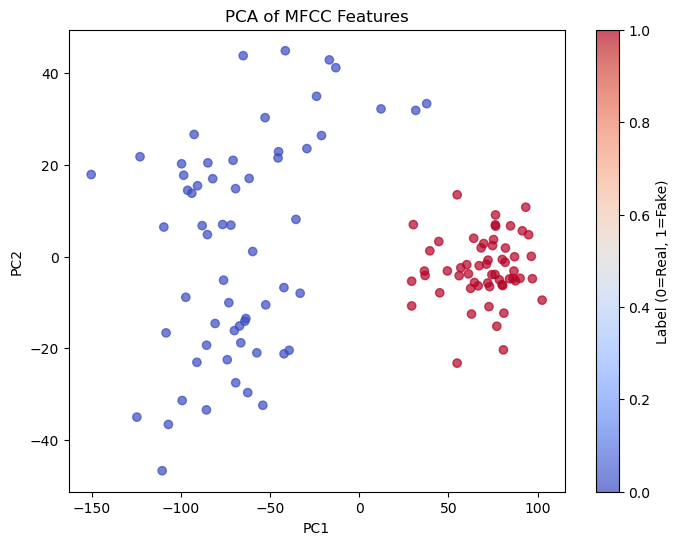

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.stack(labeled_data["features"].values)
y = labeled_data["label"].map({"real": 0, "fake": 1}).values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("PCA of MFCC Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Label (0=Real, 1=Fake)')
plt.show()

In [16]:
def get_duration(path):
    y, sr = librosa.load(path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

labeled_data["duration"] = labeled_data["file"].apply(get_duration)
labeled_data.groupby("label")["duration"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,57.0,4.784842,1.421572,2.328,3.888,4.872,5.448,10.896
real,60.0,6.698400,2.002080,3.204,5.382,6.120,8.289,11.520


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      60.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00      60.0
   macro avg       0.00      0.00      0.00      60.0
weighted avg       0.00      0.00      0.00      60.0



/Users/giovannipoveda/miniconda3/envs/machine_learning_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/giovannipoveda/miniconda3/envs/machine_learning_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/giovannipoveda/miniconda3/envs/machine_learning_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

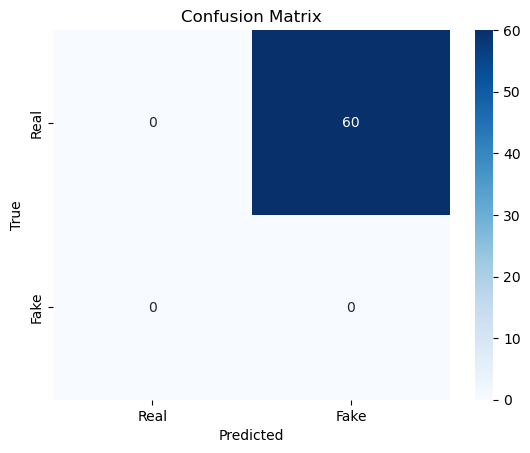

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()